<a href="https://colab.research.google.com/github/mvajhi/unsupervised-learning/blob/master/HW3/Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="recap"></a>
## Quick recap

### Normalizing flows

Normalizing flows allow to transform a probability distribution, through a series of *change of variable*. If we start with a random vector $\mathbf{z}_0$ with distribution $q_0$, we can apply a series of mappings $f_i$, $i \in 1,\cdots,k$ with $k\in\mathcal{N}^{+}$ and obtain a normalizing flow. If we apply $k$ normalizing flows, the distribution of $\mathbf{z}_k\sim q_k(\mathbf{z}_k)$ in log-probability will be given by

$$
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right|
\tag{1}
$$

Of course, we can perform any amount of combined transformations.

### PyTorch distributions

We still rely on the novel [PyTorch distributions module](https://pytorch.org/docs/stable/_modules/torch/distributions/), which is defined in `torch.distributions`.

In [1]:
%pylab inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.distributions import constraints
import matplotlib.animation as animation
matplotlib.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
from IPython.display import HTML
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Define grids of points (for later plots)

warnings.filterwarnings("ignore")
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

Populating the interactive namespace from numpy and matplotlib


### Optimizing normalizing flows

The main interest in normalizing flows is that we could optimize the parameters of these flow in order to fit complex and rich probability distributions. In order to perform *inference*, we had to deal with the fact that the `Transform` object is not inherently parametric. To do so, we define our own `Flow` class which can be seen both as a `Transform` and also a `Module`that can be optmized

In [2]:
class Flow(transform.Transform, nn.Module):

    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
        self.domain = constraints.real_vector
        self.codomain = constraints.real_vector
        self.bijective = True

    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)

    def __hash__(self):
        return nn.Module.__hash__(self)

Based on this minimal class, we defined a wide variety of flows in the previous tutorials, but we will here simply reuse the *planar* and *radial* flows. Therefore, we redefine here the `PlanarFlow` and `RadialFlow` classes.

In [3]:
class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)

class RadialFlow(Flow):

    def __init__(self, dim):
        super(RadialFlow, self).__init__()
        self.z0 = nn.Parameter(torch.Tensor(1, dim))
        self.alpha = nn.Parameter(torch.Tensor(1))
        self.beta = nn.Parameter(torch.Tensor(1))
        self.dim = dim
        self.init_parameters()

    def _call(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        return z + (self.beta * h * (z - self.z0))

    def log_abs_det_jacobian(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        hp = - 1 / (self.alpha + r) ** 2
        bh = self.beta * h
        det_grad = ((1 + bh) ** self.dim - 1) * (1 + bh + self.beta * hp * r)
        return torch.log(det_grad.abs() + 1e-9)

Now in order to define a sequence of such flows, we defined a `NormalizingFlow` class, which is responsible for applying a series of flows and recording their determinant

In [4]:
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det

### Minimalist VAE implementation

As we have seen, VAEs can be simply implemented by decomposing the above series of operations into an `encoder` which represents the distribution $q_\phi(\mathbf{z}\vert\mathbf{x})$, from which we will sample some values $\tilde{\mathbf{z}}$ (using the reparametrization trick) and compute the Kullback-Leibler (KL) divergence. Then, we use these values as input to a `decoder` which represents the distribution $p_\theta(\mathbf{x}\vert\mathbf{z})$ so that we can produce a reconstruction $\tilde{\mathbf{x}}$ and compute the reconstruction error. This process is implemented in the following `VAE` class.

Note that we purposedly rely on an implementation of the `encode` function where the `encoder` first produces an intermediate representation of size `encoder_dims`. Then, this representation goes through two separate functions for encoding $\mathbf{\mu}$ and $\mathbf{\sigma}$. This provides a clearer implementation but also the added bonus that we can ensure that $\mathbf{\sigma} > 0$

In [5]:
class VAE(nn.Module):

    def __init__(self, encoder, decoder, encoder_dims, latent_dims):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dims = latent_dims
        self.encoder_dims = encoder_dims
        self.mu = nn.Linear(encoder_dims, latent_dims)
        self.sigma = nn.Sequential(
            nn.Linear(encoder_dims, latent_dims),
            nn.Softplus(),
            nn.Hardtanh(min_val=1e-4, max_val=5.))
        self.apply(self.init_parameters)

    def init_parameters(self, m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        return mu, sigma

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde, kl_div

    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Retrieve mean and var
        mu, sigma = z_params
        # Re-parametrize
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        z = (sigma * q.sample((n_batch, ))) + mu
        # Compute KL divergence
        kl_div = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
        kl_div = kl_div / n_batch
        return z, kl_div

Now the interesting aspect of VAEs is that we can define any parametric function as `encoder` and `decoder`, as long as we can optimize them. Here, we will rely on simple feed-forward neural networks, but these can be largely more complex (with limitations that we will discuss later in the tutorial).

In [6]:
def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
        nn.Linear(nin, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU()
    )
    # Decoder network
    decoder = nn.Sequential(
        nn.Linear(n_latent, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, nin),
        nn.Sigmoid()
    )
    return encoder, decoder

### Evaluating the reconstruction error

In the definition of the `VAE` class, we directly included the computation of the $D_{KL}$ term to regularize our latent space. However, remember that the complete loss of equation (4) also contains a *reconstruction loss* which compares our reconstructed output to the original data.

While there are several options to compare the error between two elements, there are usually two preferred choices among the generative literature depending on how we consider our problem
1. If we consider each dimension (pixel) to be a binary unit (following a Bernoulli distribution), we can rely on the `binary cross entropy` between the two distributions
2. If we turn our problem to a set of classifications, where each dimension can belong to a given set of *intensity classes*, then we can compute the `multinomial loss` between the two distributions

In the following, we define both error functions and regroup them in the `reconstruction_loss` call (depending on the `num_classes` considered). However, as the `multinomial loss` requires a large computational overhead, and for the sake of simplicity, we will train all our first models by relying on the `binary cross entropy`

In [7]:
def binary_loss(x_tilde, x):
    return F.binary_cross_entropy(x_tilde, x, reduction='none').sum(dim = 0)

def multinomial_loss(x_logit, x):
    batch_size = x.shape[0]
    # Reshape input
    x_logit = x_logit.view(batch_size, num_classes, x.shape[1], x.shape[2], x.shape[3])
    # Take softmax
    x_logit = F.log_softmax(x_logit, 1)
    # make integer class labels
    target = (x * (num_classes - 1)).long()
    # computes cross entropy over all dimensions separately:
    ce = F.nll_loss(x_logit, target, weight=None, reduction='none')
    return ce.sum(dim = 0)*100

def reconstruction_loss(x_tilde, x, num_classes=1, average=True):
    if (num_classes == 1):
        loss = binary_loss(x_tilde, x.view(x.size(0), -1))
    else:
        loss = multinomial_loss(x_tilde, x)
    if (average):
        loss = loss.sum() / x.size(0)
    return loss

### Optimizing a VAE on a real dataset

For this tutorial, we are going to take a quick shot at a real-life problem by trying to train our VAEs on the `FashionMNIST` dataset. This dataset can be natively used in PyTorch by relying on the `torchvision.datasets` classes as follows

In [8]:
batch_size = 64
from torchvision import datasets
from torchvision import transforms
tens_t = transforms.ToTensor()
train_dset = datasets.FashionMNIST('./data', train=True, download=True, transform=tens_t)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dset = datasets.FashionMNIST('./data', train=False, transform=tens_t)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, shuffle=True)

100%|██████████| 26.4M/26.4M [00:00<00:00, 140MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.85MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 58.7MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.3MB/s]


The `FashionMNIST` dataset is composed of simple 28x28 black and white images of different items of clothings (such as shoes, bags, pants and shirts). We put a simple function here to display one batch of the test set (note that we keep a fixed batch from the test set in order to evaluate the different variations that we will try in this tutorial).

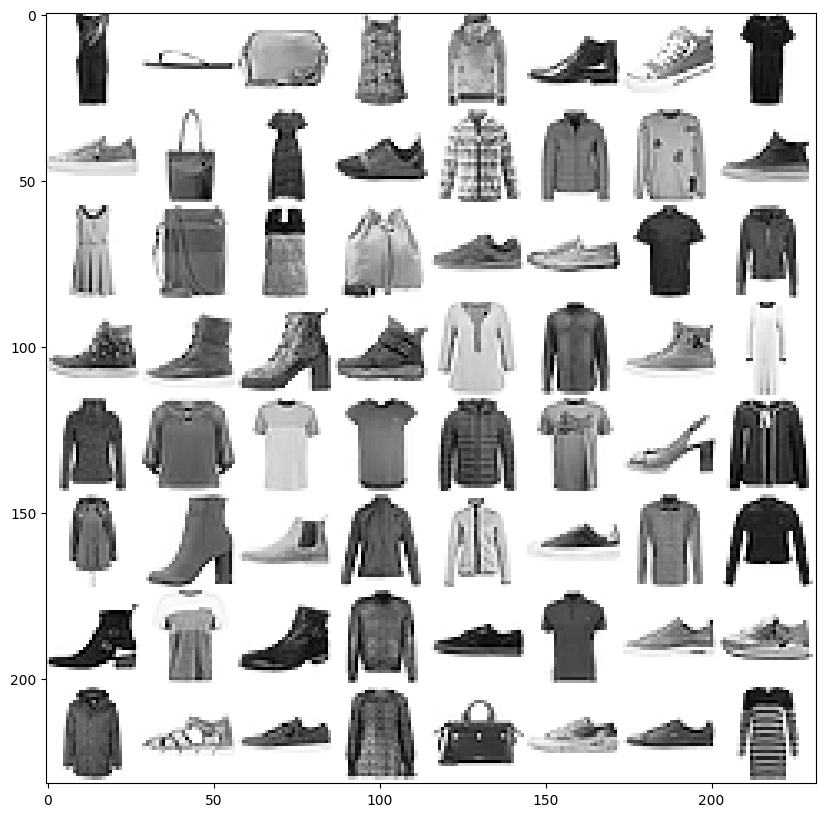

In [9]:
def plot_batch(batch, nslices=8):
    # Create one big image for plot
    img = np.zeros(((batch.shape[2] + 1) * nslices, (batch.shape[3] + 1) * nslices))
    for b in range(batch.shape[0]):
        row = int(b / nslices); col = int(b % nslices)
        r_p = row * batch.shape[2] + row; c_p = col * batch.shape[3] + col
        img[r_p:(r_p+batch.shape[2]),c_p:(c_p+batch.shape[3])] = torch.sum(batch[b], 0)
    im = plt.imshow(img, cmap='Greys', interpolation='nearest'),
    return im
# Select a random set of fixed data
fixed_batch, fixed_targets = next(iter(test_loader))
plt.figure(figsize=(10, 10))
plot_batch(fixed_batch);

Now based on our proposed implementation, the optimization aspects are defined in a very usual way

In [10]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Compute input dimensionality
nin = fixed_batch.shape[2] * fixed_batch.shape[3]
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_latent, n_hidden, num_classes)
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)
# Create optimizer algorithm
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

Now all that is left to do is train the model. We define here a `train_vae` function that we will reuse along the future implementations and variations of VAEs and flows. Note that this function is set to run for only a very few number of `epochs` and also most importantly, *only considers a subsample of the full dataset at each epoch*. This option is just here so that you can test the different models very quickly on any CPU or laptop.

In [ ]:
def train_vae(model, optimizer, scheduler, train_loader, fixed_batch, model_name='basic', epochs=50, plot_it=1, subsample=5000, flatten=True):
    # Losses curves
    losses = torch.zeros(epochs, 2)
    # Beta-warmup
    beta = 0
    # Plotting
    ims = []
    fig = plt.figure(figsize=(10, 10))
    # Main optimization loop
    for it in range(epochs):
        it_loss = torch.Tensor([2])
        # Update our beta
        beta = 1. * (it / float(epochs))
        n_batch = 0.
        # Evaluate loss and backprop
        for batch_idx, (x, _) in enumerate(train_loader):
            if (batch_idx * batch_size) > subsample:
                break
            # Flatten input data
            if (flatten):
                x = x.view(-1, nin)
            # Pass through VAE
            x_tilde, loss_latent = model(x)
            # Compute reconstruction loss
            loss_recons = reconstruction_loss(x_tilde, x, num_classes)
            # Evaluate loss and backprop
            loss = loss_recons + (beta * loss_latent)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            losses[it, 0] += loss_recons.item()
            losses[it, 1] += loss_latent.item()
            n_batch += 1.
        losses[it, :] /= n_batch
        if (it % plot_it == 0):
            # Encode our fixed batch
            samples = fixed_batch
            if (flatten):
                samples = fixed_batch.view(-1, nin)
            x_tilde, _ = model(samples)
            if (num_classes > 1):
                # Find largest class logit
                tmp = x_tilde.view(-1, num_classes, *x[0].shape[1:]).max(dim=1)[1]
                x_tilde = tmp.float() / (num_classes - 1.)
            ims.append(plot_batch(x_tilde.detach().view_as(fixed_batch)))
            plt.title('Iter.%i'%(it), fontsize=15);
    # Generate our animation
    anim = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    HTML(anim.to_html5_video())
    anim.save("vae_" + model_name + ".mp4")
    return losses

# Launch our optimization
losses_kld = train_vae(model, optimizer, scheduler, train_loader, fixed_batch, model_name='basic', epochs=100)

### Evaluating generative models

In order to evaluate our upcoming generative models, we will rely on the computation of the Negative Log-Likelihood. This code for the following `evaluate_nll_bpd` is inspired by the [Sylvester flow repository](https://github.com/riannevdberg/sylvester-flows)

In [ ]:
from scipy.special import logsumexp

def evaluate_nll_bpd(data_loader, model, batch = 500, R = 5):
    model.eval()
    # Set of likelihood tests
    likelihood_test = []
    # Go through dataset
    for batch_idx, (x, _) in enumerate(data_loader):
        for j in range(x.shape[0]):
            a = []
            for r in range(0, R):
                cur_x = x[j].unsqueeze(0)
                # Repeat it as batch
                x = cur_x.expand(batch, *cur_x.size()[1:]).contiguous()
                x = x.view(batch, -1)
                x_tilde, kl_div = model(x)
                rec = reconstruction_loss(x_tilde, x, average=False)
                a_tmp = (rec + kl_div)
                a.append(- a_tmp.cpu().data.numpy())
            # calculate max
            a = np.asarray(a)
            a = np.reshape(a, (a.shape[0] * a.shape[1], 1))
            likelihood_x = logsumexp(a)
            likelihood_test.append(likelihood_x - np.log(len(a)))
    likelihood_test = np.array(likelihood_test)
    nll = - np.mean(likelihood_test)
    # Compute the bits per dim (but irrelevant for binary data)
    bpd = nll / (np.prod(nin) * np.log(2.))
    return nll, bpd

Now we can evaluate our VAE model more formally as follows.

In [ ]:
# Plot final loss
plt.figure()
plt.plot(losses_kld[:, 0].numpy());
# Evaluate log-likelihood and bits per dim
nll, _ = evaluate_nll_bpd(test_loader, model)
print('Negative Log-Likelihood : ' + str(nll))

<a id="vae"></a>
## Normalizing flows and VAEs

### Flows as posterior

In this first implementation of VAEs augmented with normalizing flows, we simply add a flow after the prior sampling. This is implemented in the following `VAENormalizingFlow` class. Note that the computation of different parts of the latent regularizations and the log determinants is performed explicitly here

In [ ]:
class VAENormalizingFlow(VAE):

    def __init__(self, encoder, decoder, flow, encoder_dims, latent_dims):
        super(VAENormalizingFlow, self).__init__(encoder, decoder, encoder_dims, latent_dims)
        self.flow = flow

    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Retrieve set of parameters
        mu, sigma = z_params
        # Re-parametrize a Normal distribution
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        # Obtain our first set of latent points
        z_0 = (sigma * q.sample((n_batch, ))) + mu
        # Complexify posterior with flows
        z_k, list_ladj = self.flow(z_0)
        # ln p(z_k)
        log_p_zk = -0.5 * z_k * z_k
        # ln q(z_0)
        log_q_z0 = -0.5 * (sigma.log() + (z_0 - mu) * (z_0 - mu) * sigma.reciprocal())
        #  ln q(z_0) - ln p(z_k)
        logs = (log_q_z0 - log_p_zk).sum()
        # Add log determinants
        ladj = torch.cat(list_ladj)
        # ln q(z_0) - ln p(z_k) - sum[log det]
        logs -= torch.sum(ladj)
        return z_k, (logs / float(n_batch))

As we can see, this model behaves almost exactly like the Vanilla `VAE`. However, we now complexify the latent distribution with a given `flow` and then replace the KL divergence with the regularization based on the variational free energy. Note also that we rely on the implementation of `Flow` from the previous tutorial, where each flow optimizes its own parameters. Therefore, we can simply optimize this model similarily as the previous one.

In [ ]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Our MLP blocks
block_planar = [PlanarFlow]
# Create normalizing flow
flow = NormalizingFlow(n_latent, block_planar, 1, distrib.Normal(torch.zeros(n_latent), torch.ones(n_latent)))
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_latent, n_hidden, num_classes)
# Create VAE with planar flows
model_flow = VAENormalizingFlow(encoder, decoder, flow, n_hidden, n_latent)
# Create optimizer algorithm
optimizer = optim.Adam(model_flow.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
# Launch our optimization
losses_flow = train_vae(model_flow, optimizer, scheduler, train_loader, fixed_batch, model_name='flow', epochs=100)

Now we can compare this improved VAE model with a normalizing flow to the original vanilla VAE on our log-likelihood criterion

In [ ]:
# Plot losses
plt.figure()
plt.plot(losses_flow[:, 0].numpy());
# Evaluate log-likelihood and bits per dim
nll, _ = evaluate_nll_bpd(test_loader, model_flow)
print('Negative Log-Likelihood : ' + str(nll))

### Comparing the latent spaces of different models

One of the key aspect in the difference between the vanilla VAE and the VAE with normalizing flow is the treatment of the latent space. Hence a good way of assessing the impact of our flows is to check how the flow process the latent points. Here, we perform some visualisations of the latent spaces obtained

In [ ]:
from sklearn import decomposition
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
models = {'vanilla':(model, ax1), 'planar indep.':(model_flow, ax2), 'planar params':(model_flow_p, ax3)}
for name, (cur_model, ax) in models.items():
    final_z = []
    final_classes = []
    for batch_idx, (x, c) in enumerate(train_loader):
        if (x.shape[0] != 64):
            break
        x = (x.view(x.shape[0], -1) * 2) - 1
        # Not exact but just consider mean for laziness
        cur_mu, cur_sig, *params = cur_model.encode(x)
        q = distrib.Normal(torch.zeros(cur_mu.shape[1]), torch.ones(cur_sig.shape[1]))
        cur_z = (cur_sig * q.sample((64, ))) + cur_mu
        if (hasattr(cur_model, 'flow')):
            if (name == 'planar params'):
                cur_model.flow.set_parameters(params[0])
            cur_z, _ = cur_model.flow(cur_z)
        final_z.append(cur_z.detach())
        final_classes.append(c)
    final_z = torch.cat(final_z)
    final_classes = torch.cat(final_classes)
    # Create PCA and apply it to our data
    pca = decomposition.PCA(n_components=2)
    z_pca = pca.fit_transform(final_z)
    # then apply the PCA to a value and call it z_pca
    ax.scatter(z_pca[:, 0], z_pca[:, 1], c=final_classes, cmap=plt.cm.nipy_spectral, edgecolor='k')
    ax.set_title(name)